In [3]:
import numpy as np
from testCases_v3 import *
import matplotlib.pyplot as plt
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [4]:
#Dataset
from dnn_utils_v2 import *

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print('Train')
print(train_x.shape)
print(train_y.shape)
print('Test')
print(test_x.shape)
print(test_y.shape)

Train
(12288, 209)
(1, 209)
Test
(12288, 50)
(1, 50)


(209, 64, 64, 3)
y = 0. It's a non-cat picture.


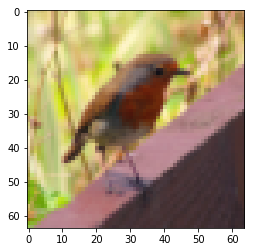

In [5]:
# Example of a picture
index = 10
print(train_x_orig.shape)
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
σ = lambda Z: (1/(1 + np.exp(-Z)))
dσ = lambda Z: (σ(Z) * (1 - σ(Z)))
Relu = lambda Z: (np.maximum(0,Z))
#dRelu = lambda Z: ((Z > 0) * 1)
dRelu = lambda Z: (Z > 0)
#Relu's derivative: 0 if Z[i] <= 0 and 1 if Z[i] > 0

In [7]:
def forward_propagation(X, Weights, Dropout = 0):
    L = len(Weights)
    caches = []

    ##################
    Drops = []
    ##################
    
    A = X
    seed = 1
    for l in range(L-1):
        W,b = Weights[l]

        A_prev = A

        Z = np.dot(W, A_prev) + b
        A = Relu(Z)

        #######DROPUT########
        if Dropout > 0:
            np.random.seed(seed)
            #Drop = np.random.randn(A.shape[0], A.shape[1]) > 0.5
            Drop = np.random.randn(A.shape[0], A.shape[1]) < Dropout
            A = A * Drop
        #####################

        caches.append((A_prev, W, Z))

        ######################
        if Dropout > 0:
            Drops.append(Drop)
        ######################

        seed = seed + 1
        
    A_prev = A
    #Last layer
    W,b = Weights[L-1]

    Z = np.dot(W, A_prev) + b
    y_hat = σ(Z)

    caches.append((A_prev, W, Z))

    ###########Returning Drops################
    return y_hat, caches, Drops

In [8]:
def backpropagation(y_hat, y, caches, Drops, Dropout = 0):
    ############Recieves Drops############
    L = len(caches)
    m = y_hat.shape[1]
    grads = []

    A_prev, W, Z = caches[L-1]
    #Last layer
    dy_hat = ( (1-y)/(1-y_hat) ) - ( y/y_hat )
    dZ = dy_hat * dσ(Z)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    grads.append((dW,db))

    for l in reversed(range(L-1)):
        A_prev, W, Z = caches[l]  

        ####################
        if Dropout > 0:
            dA = dA * Drops[l]
        ####################
  
        dZ = dA * dRelu(Z)
        dW = 1/m * np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W.T, dZ)

        grads.append((dW,db))

    grads = list(reversed(grads))
    return grads

In [9]:
def initialize(layer_dimensions):
    #layer_dimensions[0] is the input layer size
    np.random.seed(1)
    L = len(layer_dimensions)
    Weigths = []

    for l in range(1,L):
        W = np.random.randn(layer_dimensions[l],layer_dimensions[l-1]) / np.sqrt(layer_dimensions[l-1])
        b = np.zeros((layer_dimensions[l],1))

        Weigths.append((W,b))

    return Weigths

In [10]:
cross_entropy_loss = lambda y_hat, y: np.squeeze(( 1/y.shape[1] * (-np.dot(y,np.log(y_hat).T) - np.dot(1-y, np.log(1-y_hat).T)) ) )

In [11]:
def update(Weights, α, grads):
    L = len(Weights)

    for l in range(L):
        W,b = Weights[l]

        dW, db = grads[l]
        Weights[l] = W-α*dW, b-α*db

    return Weights

In [12]:
#Final L-layer model
def model(X,y, layer_dimensions, α, iters, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weigts = initialize(layer_dimensions)

    for i in range(iters):
        
        ##############Drops############
        y_hat, caches, Drops = forward_propagation(X, Weigts, Dropout = Dropout)

        cost = cross_entropy_loss(y_hat, y)
        
        #############Drops############
        grads = backpropagation(y_hat, y, caches, Drops, Dropout= Dropout)
        
        Weigts = update(Weigts, α, grads)  

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    costs = np.squeeze(costs)
    return Weigts, costs

Podemos usar minibatches, los cuales nos permiten actualizaciones más rápidas de los gradientes, al usar pedazos del dataset.

In [13]:
def get_mini_batches(X, y, batch_size, seed):
    m = X.shape[1]
    #Cambiamos la semilla cada iteración
    np.random.seed(seed)
    
    #Se permutan de manera aleatoria todos los índices del 0 a m-1
    perm_index = list(np.random.permutation(m))
    #Permutamos las columnas en base a la distribución de índices obtenidos
    sX = X[:, perm_index]
    sy = y[:, perm_index]
    
    #Número de mini batches completos
    rnge = int(m/batch_size)

    minibatch = []
    for i in range(rnge):
        #Agarramos ese bloque de tamaño definido
        minibatch.append((sX[:,batch_size*i:batch_size*(i+1)], sy[:,batch_size*i:batch_size*(i+1)]))
        
        #Si estamos en la última pasada y aún sobran unos cuntos ejemplos, los agarramos como un mini batch aparte
        if(i+1 == rnge and m%batch_size != 0):
            minibatch.append((sX[:,batch_size*(i+1):sX.shape[1]], sy[:,batch_size*(i+1):sy.shape[1]]))

    return minibatch

In [14]:
def model_minibatches(X,y, layer_dimensions, α, iters, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weights = initialize(layer_dimensions)

    seed = 10

    for i in range(iters):
        
        #mini batches
        seed = seed + 1
        
        minibatches = get_mini_batches(X, y, 90, seed)
        
        for minibatch in minibatches:
            
            minibatch_X, minibatch_Y = minibatch
            
            ##############Drops############
            y_hat, caches, Drops = forward_propagation(minibatch_X, Weights, Dropout=Dropout)
    
            cost = cross_entropy_loss(y_hat, minibatch_Y)
         
            ##############Drops############
            grads = backpropagation(y_hat, minibatch_Y, caches, Drops, Dropout=Dropout)

            Weights = update(Weights, α, grads)  

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    costs = np.squeeze(costs)
    return Weights, costs

In [15]:
def model_adam(X, y, layer_dimensions, α, iters, β1=0.9, β2=0.999, ϵ=1e-8, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weights = initialize(layer_dimensions)

    seed = 10
    
    #INITIALIZE MOMENTS
    L = len(Weights)
    mw,vw = [],[]
    mb,vb = [],[]
    for l in range(L):
        mw.append(np.zeros(Weights[l][0].shape))
        vw.append(np.zeros(Weights[l][0].shape))
        mb.append(np.zeros(Weights[l][1].shape))
        vb.append(np.zeros(Weights[l][1].shape))

    t = 0

    for i in range(iters):
        
        seed = seed + 1

        minibatches = get_mini_batches(X, y, 90, seed)

        for minibatch in minibatches:

            minibatch_X, minibatch_Y = minibatch

            y_hat, caches, Drops = forward_propagation(minibatch_X, Weights, Dropout = Dropout)

            cost = cross_entropy_loss(y_hat, minibatch_Y)

            grad = backpropagation(y_hat, minibatch_Y, caches, Drops, Dropout=Dropout)

            ##################UPDATE RULE##############
            t = t + 1
            for l in range(L):
                W, b = Weights[l]
                ΔW, Δb = grad[l]
                #Updating moments
                mw[l] = β1*mw[l] + (1-β1)*ΔW
                vw[l] = β2*vw[l] + (1-β2)*(ΔW**2)

                mb[l] = β1*mb[l] + (1-β1)*Δb
                vb[l] = β2*vb[l] + (1-β2)*(Δb**2)
                
                #Bias correction
                mw_hat = mw[l]/(1-(β1**t))
                vw_hat = vw[l]/(1-(β2**t))
                
                mb_hat = mb[l]/(1-(β1**t))
                vb_hat = vb[l]/(1-(β2**t))

                #Update
                W = W - α*(mw_hat/(np.sqrt(vw_hat) + ϵ))
                b = b - α*(mb_hat/(np.sqrt(vb_hat) + ϵ))
                Weights[l] = (W,b)
                
                """αt = α * np.sqrt(1-β2**t)/(1-β1**t)
                W = W - αt * mw[l]/(np.sqrt(vw[l]) + ϵ)
                b = b - αt * mb[l]/(np.sqrt(vb[l]) + ϵ)
                Weights[l] = (W,b)"""

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    costs = np.squeeze(costs)
    return Weights, costs

Cost after iteration 0: 0.637100
Cost after iteration 100: 0.068847
Cost after iteration 200: 0.012445
Cost after iteration 300: 0.004021
Cost after iteration 400: 0.000922
Cost after iteration 500: 0.000080
Cost after iteration 600: 0.000085
Cost after iteration 700: 0.000062
Cost after iteration 800: 0.000033
Cost after iteration 900: 0.000024
Cost after iteration 1000: 0.000012
Cost after iteration 1100: 0.000010
Cost after iteration 1200: 0.000010
Cost after iteration 1300: 0.000010
Cost after iteration 1400: 0.000004
Cost after iteration 1500: 0.000003
Cost after iteration 1600: 0.000002
Cost after iteration 1700: 0.000006
Cost after iteration 1800: 0.000006
Cost after iteration 1900: 0.000001
Cost after iteration 2000: 0.000002
Cost after iteration 2100: 0.000000
Cost after iteration 2200: 0.000001
Cost after iteration 2300: 0.000000
Cost after iteration 2400: 0.000001


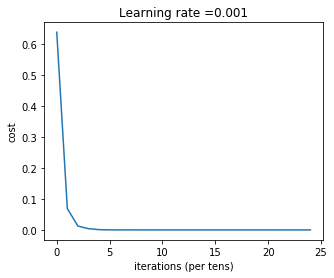

In [31]:
#layer_dimensions = [12288, 7, 1]
#layer_dimensions = [12288, 9500, 3400, 980, 420, 110, 30, 7, 1]
layer_dimensions = [12288, 100, 20, 1]
#α = 0.0075
α = 0.001
#iters = 2500
iters = 2500
#Para adam usar iters = 1000 y α = 0.001
Weights, costs = model_adam(train_x, train_y, layer_dimensions, α, iters, print_cost=True)

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(α))
plt.show()

In [16]:
def check(X, y, Weigths):
    ##############
    preds, _, _ = forward_propagation(X, Weigths)
    preds = (preds > 0.5)*1

    pos = 0
    m = preds.shape[1]
    for i in range(m):
        if y[0][i] == preds[0][i]:
           pos += 1

    print(str(pos/m*100)+'% Accuracy')

In [32]:
print('Train')
check(train_x, train_y, Weights)
print('Test')
check(test_x, test_y, Weights)

Train
100.0% Accuracy
Test
76.0% Accuracy


In [36]:
import cv2
def predict(test, Weights, image=True):
    if image == True:
        orig = cv2.imread(test)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

        test = cv2.resize(cv2.imread(test), (64,64), interpolation = cv2.INTER_AREA)
        test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

    #plot image
    plt.imshow(orig)
    plt.plot()
    #flatten image
    test =  np.reshape(test.flatten(), (12288,1)) / 255

    ##################
    pred, _, _ = forward_propagation(test, Weights)
    #print(pred)
    pred = pred > 0.5
    #print(pred)
    if pred == 1:
        print('It is a cat')
    else:
        print('It is not a cat')

It is a cat


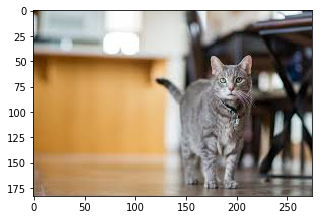

In [37]:
predict('test9.jpg', Weights)
#predict(train_x_orig[11,:,:,:], Weights, image=True)

Ahora aplicaremos la misma idea en Keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [21]:
keras_model = Sequential()
keras_model.add(Dense(100, input_dim = 12288, activation = 'relu'))
keras_model.add(Dense(20, activation = 'relu'))
keras_model.add(Dense(1, activation = 'sigmoid'))

In [25]:
keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
keras_model.fit(train_x.T, train_y.T, epochs=2500, batch_size=90)

Epoch 1/2500
209/209 [==============================] - 0s - loss: 1.7549 - acc: 0.5742     
Epoch 2/2500
209/209 [==============================] - 0s - loss: 2.8667 - acc: 0.3493     
Epoch 3/2500
209/209 [==============================] - 0s - loss: 1.2079 - acc: 0.6555     
Epoch 4/2500
209/209 [==============================] - 0s - loss: 0.8031 - acc: 0.5550     
Epoch 5/2500
209/209 [==============================] - 0s - loss: 0.7833 - acc: 0.5502     
Epoch 6/2500
209/209 [==============================] - 0s - loss: 0.8099 - acc: 0.6555     
Epoch 7/2500
209/209 [==============================] - 0s - loss: 0.7245 - acc: 0.4928     
Epoch 8/2500
209/209 [==============================] - 0s - loss: 0.7212 - acc: 0.6555     
Epoch 9/2500
209/209 [==============================] - 0s - loss: 0.6466 - acc: 0.6077     
Epoch 10/2500
209/209 [==============================] - 0s - loss: 0.5990 - acc: 0.6890     
Epoch 11/2500
209/209 [==============================] - 0s - loss: 0

209/209 [==============================] - 0s - loss: 0.1503 - acc: 0.9761     
Epoch 89/2500
209/209 [==============================] - 0s - loss: 0.1494 - acc: 0.9761     
Epoch 90/2500
209/209 [==============================] - 0s - loss: 0.1616 - acc: 0.9665     
Epoch 91/2500
209/209 [==============================] - 0s - loss: 0.1513 - acc: 0.9761     
Epoch 92/2500
209/209 [==============================] - 0s - loss: 0.2280 - acc: 0.8708     
Epoch 93/2500
209/209 [==============================] - 0s - loss: 0.2164 - acc: 0.9330     
Epoch 94/2500
209/209 [==============================] - 0s - loss: 0.2019 - acc: 0.8995     
Epoch 95/2500
209/209 [==============================] - 0s - loss: 0.2272 - acc: 0.9091     
Epoch 96/2500
209/209 [==============================] - 0s - loss: 0.2001 - acc: 0.9139     
Epoch 97/2500
209/209 [==============================] - 0s - loss: 0.1846 - acc: 0.9522     
Epoch 98/2500
209/209 [==============================] - 0s - loss: 0.1333

209/209 [==============================] - 0s - loss: 0.0249 - acc: 1.0000     
Epoch 175/2500
209/209 [==============================] - 0s - loss: 0.0263 - acc: 1.0000     
Epoch 176/2500
209/209 [==============================] - 0s - loss: 0.0232 - acc: 1.0000     
Epoch 177/2500
209/209 [==============================] - 0s - loss: 0.0232 - acc: 1.0000     
Epoch 178/2500
209/209 [==============================] - 0s - loss: 0.0228 - acc: 1.0000     
Epoch 179/2500
209/209 [==============================] - 0s - loss: 0.0254 - acc: 1.0000     
Epoch 180/2500
209/209 [==============================] - 0s - loss: 0.0215 - acc: 1.0000     
Epoch 181/2500
209/209 [==============================] - 0s - loss: 0.0232 - acc: 1.0000     
Epoch 182/2500
209/209 [==============================] - 0s - loss: 0.0213 - acc: 1.0000     
Epoch 183/2500
209/209 [==============================] - 0s - loss: 0.0202 - acc: 1.0000     
Epoch 184/2500
209/209 [==============================] - 0s - lo

209/209 [==============================] - 0s - loss: 0.0066 - acc: 1.0000     
Epoch 261/2500
209/209 [==============================] - 0s - loss: 0.0064 - acc: 1.0000     
Epoch 262/2500
209/209 [==============================] - 0s - loss: 0.0063 - acc: 1.0000     
Epoch 263/2500
209/209 [==============================] - 0s - loss: 0.0061 - acc: 1.0000     
Epoch 264/2500
209/209 [==============================] - 0s - loss: 0.0059 - acc: 1.0000     
Epoch 265/2500
209/209 [==============================] - 0s - loss: 0.0058 - acc: 1.0000     
Epoch 266/2500
209/209 [==============================] - 0s - loss: 0.0058 - acc: 1.0000     
Epoch 267/2500
209/209 [==============================] - 0s - loss: 0.0057 - acc: 1.0000     
Epoch 268/2500
209/209 [==============================] - 0s - loss: 0.0057 - acc: 1.0000     
Epoch 269/2500
209/209 [==============================] - 0s - loss: 0.0056 - acc: 1.0000     
Epoch 270/2500
209/209 [==============================] - 0s - lo

209/209 [==============================] - 0s - loss: 0.0019 - acc: 1.0000     
Epoch 347/2500
209/209 [==============================] - 0s - loss: 0.0018 - acc: 1.0000     
Epoch 348/2500
209/209 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 349/2500
209/209 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 350/2500
209/209 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 351/2500
209/209 [==============================] - 0s - loss: 0.0015 - acc: 1.0000        
Epoch 352/2500
209/209 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 353/2500
209/209 [==============================] - 0s - loss: 0.0013 - acc: 1.0000     
Epoch 354/2500
209/209 [==============================] - 0s - loss: 0.0013 - acc: 1.0000     
Epoch 355/2500
209/209 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 356/2500
209/209 [==============================] - 0s -

209/209 [==============================] - 0s - loss: 2.1413e-04 - acc: 1.0000     
Epoch 430/2500
209/209 [==============================] - 0s - loss: 2.1078e-04 - acc: 1.0000     
Epoch 431/2500
209/209 [==============================] - 0s - loss: 2.0293e-04 - acc: 1.0000     
Epoch 432/2500
209/209 [==============================] - 0s - loss: 2.0077e-04 - acc: 1.0000     
Epoch 433/2500
209/209 [==============================] - 0s - loss: 1.9580e-04 - acc: 1.0000     
Epoch 434/2500
209/209 [==============================] - 0s - loss: 1.9388e-04 - acc: 1.0000     
Epoch 435/2500
209/209 [==============================] - 0s - loss: 1.9079e-04 - acc: 1.0000     
Epoch 436/2500
209/209 [==============================] - 0s - loss: 1.9326e-04 - acc: 1.0000     
Epoch 437/2500
209/209 [==============================] - 0s - loss: 1.8892e-04 - acc: 1.0000     
Epoch 438/2500
209/209 [==============================] - 0s - loss: 1.8320e-04 - acc: 1.0000     
Epoch 439/2500
209/209 [=

209/209 [==============================] - 0s - loss: 8.4667e-05 - acc: 1.0000     
Epoch 512/2500
209/209 [==============================] - 0s - loss: 8.4008e-05 - acc: 1.0000     
Epoch 513/2500
209/209 [==============================] - 0s - loss: 8.4110e-05 - acc: 1.0000     
Epoch 514/2500
209/209 [==============================] - 0s - loss: 8.3280e-05 - acc: 1.0000     
Epoch 515/2500
209/209 [==============================] - 0s - loss: 8.1619e-05 - acc: 1.0000     
Epoch 516/2500
209/209 [==============================] - 0s - loss: 8.2645e-05 - acc: 1.0000     
Epoch 517/2500
209/209 [==============================] - 0s - loss: 8.3249e-05 - acc: 1.0000     
Epoch 518/2500
209/209 [==============================] - 0s - loss: 8.1817e-05 - acc: 1.0000     
Epoch 519/2500
209/209 [==============================] - 0s - loss: 7.9403e-05 - acc: 1.0000     
Epoch 520/2500
209/209 [==============================] - 0s - loss: 7.9063e-05 - acc: 1.0000     
Epoch 521/2500
209/209 [=

209/209 [==============================] - 0s - loss: 4.7712e-05 - acc: 1.0000     
Epoch 594/2500
209/209 [==============================] - 0s - loss: 4.7398e-05 - acc: 1.0000     
Epoch 595/2500
209/209 [==============================] - 0s - loss: 4.6980e-05 - acc: 1.0000     
Epoch 596/2500
209/209 [==============================] - 0s - loss: 4.6696e-05 - acc: 1.0000     
Epoch 597/2500
209/209 [==============================] - 0s - loss: 4.6504e-05 - acc: 1.0000     
Epoch 598/2500
209/209 [==============================] - 0s - loss: 4.6237e-05 - acc: 1.0000     
Epoch 599/2500
209/209 [==============================] - 0s - loss: 4.5837e-05 - acc: 1.0000     
Epoch 600/2500
209/209 [==============================] - 0s - loss: 4.5544e-05 - acc: 1.0000     
Epoch 601/2500
209/209 [==============================] - 0s - loss: 4.5346e-05 - acc: 1.0000     
Epoch 602/2500
209/209 [==============================] - 0s - loss: 4.5250e-05 - acc: 1.0000     
Epoch 603/2500
209/209 [=

209/209 [==============================] - 0s - loss: 3.0939e-05 - acc: 1.0000     
Epoch 676/2500
209/209 [==============================] - 0s - loss: 3.0670e-05 - acc: 1.0000     
Epoch 677/2500
209/209 [==============================] - 0s - loss: 3.0430e-05 - acc: 1.0000     
Epoch 678/2500
209/209 [==============================] - 0s - loss: 3.0494e-05 - acc: 1.0000     
Epoch 679/2500
209/209 [==============================] - 0s - loss: 3.0567e-05 - acc: 1.0000     
Epoch 680/2500
209/209 [==============================] - 0s - loss: 3.0416e-05 - acc: 1.0000     
Epoch 681/2500
209/209 [==============================] - 0s - loss: 3.0314e-05 - acc: 1.0000     
Epoch 682/2500
209/209 [==============================] - 0s - loss: 3.0098e-05 - acc: 1.0000     
Epoch 683/2500
209/209 [==============================] - 0s - loss: 2.9630e-05 - acc: 1.0000     
Epoch 684/2500
209/209 [==============================] - 0s - loss: 2.9520e-05 - acc: 1.0000     
Epoch 685/2500
209/209 [=

209/209 [==============================] - 0s - loss: 2.1498e-05 - acc: 1.0000     
Epoch 758/2500
209/209 [==============================] - 0s - loss: 2.1417e-05 - acc: 1.0000     
Epoch 759/2500
209/209 [==============================] - 0s - loss: 2.1391e-05 - acc: 1.0000     
Epoch 760/2500
209/209 [==============================] - 0s - loss: 2.1337e-05 - acc: 1.0000     
Epoch 761/2500
209/209 [==============================] - 0s - loss: 2.1230e-05 - acc: 1.0000     
Epoch 762/2500
209/209 [==============================] - 0s - loss: 2.1408e-05 - acc: 1.0000     
Epoch 763/2500
209/209 [==============================] - 0s - loss: 2.1114e-05 - acc: 1.0000     
Epoch 764/2500
209/209 [==============================] - 0s - loss: 2.1290e-05 - acc: 1.0000     
Epoch 765/2500
209/209 [==============================] - 0s - loss: 2.1175e-05 - acc: 1.0000     
Epoch 766/2500
209/209 [==============================] - 0s - loss: 2.0942e-05 - acc: 1.0000     
Epoch 767/2500
209/209 [=

209/209 [==============================] - 0s - loss: 1.5867e-05 - acc: 1.0000     
Epoch 840/2500
209/209 [==============================] - 0s - loss: 1.5800e-05 - acc: 1.0000     
Epoch 841/2500
209/209 [==============================] - 0s - loss: 1.5713e-05 - acc: 1.0000     
Epoch 842/2500
209/209 [==============================] - 0s - loss: 1.5646e-05 - acc: 1.0000     
Epoch 843/2500
209/209 [==============================] - 0s - loss: 1.5596e-05 - acc: 1.0000     
Epoch 844/2500
209/209 [==============================] - 0s - loss: 1.5553e-05 - acc: 1.0000     
Epoch 845/2500
209/209 [==============================] - 0s - loss: 1.5516e-05 - acc: 1.0000     
Epoch 846/2500
209/209 [==============================] - 0s - loss: 1.5435e-05 - acc: 1.0000     
Epoch 847/2500
209/209 [==============================] - 0s - loss: 1.5386e-05 - acc: 1.0000     
Epoch 848/2500
209/209 [==============================] - 0s - loss: 1.5343e-05 - acc: 1.0000     
Epoch 849/2500
209/209 [=

209/209 [==============================] - 0s - loss: 1.2046e-05 - acc: 1.0000     
Epoch 922/2500
209/209 [==============================] - 0s - loss: 1.2046e-05 - acc: 1.0000     
Epoch 923/2500
209/209 [==============================] - 0s - loss: 1.2009e-05 - acc: 1.0000     
Epoch 924/2500
209/209 [==============================] - 0s - loss: 1.1967e-05 - acc: 1.0000     
Epoch 925/2500
209/209 [==============================] - 0s - loss: 1.1904e-05 - acc: 1.0000     
Epoch 926/2500
209/209 [==============================] - 0s - loss: 1.1878e-05 - acc: 1.0000     
Epoch 927/2500
209/209 [==============================] - 0s - loss: 1.1840e-05 - acc: 1.0000     
Epoch 928/2500
209/209 [==============================] - 0s - loss: 1.1794e-05 - acc: 1.0000     
Epoch 929/2500
209/209 [==============================] - 0s - loss: 1.1747e-05 - acc: 1.0000     
Epoch 930/2500
209/209 [==============================] - 0s - loss: 1.1729e-05 - acc: 1.0000     
Epoch 931/2500
209/209 [=

209/209 [==============================] - 0s - loss: 9.4528e-06 - acc: 1.0000     
Epoch 1004/2500
209/209 [==============================] - 0s - loss: 9.4174e-06 - acc: 1.0000     
Epoch 1005/2500
209/209 [==============================] - 0s - loss: 9.3734e-06 - acc: 1.0000     
Epoch 1006/2500
209/209 [==============================] - 0s - loss: 9.3497e-06 - acc: 1.0000     
Epoch 1007/2500
209/209 [==============================] - 0s - loss: 9.3368e-06 - acc: 1.0000     
Epoch 1008/2500
209/209 [==============================] - 0s - loss: 9.3220e-06 - acc: 1.0000     
Epoch 1009/2500
209/209 [==============================] - 0s - loss: 9.3133e-06 - acc: 1.0000     
Epoch 1010/2500
209/209 [==============================] - 0s - loss: 9.3103e-06 - acc: 1.0000     
Epoch 1011/2500
209/209 [==============================] - 0s - loss: 9.2733e-06 - acc: 1.0000     
Epoch 1012/2500
209/209 [==============================] - 0s - loss: 9.2007e-06 - acc: 1.0000     
Epoch 1013/2500


209/209 [==============================] - 0s - loss: 7.5173e-06 - acc: 1.0000     
Epoch 1086/2500
209/209 [==============================] - 0s - loss: 7.5019e-06 - acc: 1.0000     
Epoch 1087/2500
209/209 [==============================] - 0s - loss: 7.5017e-06 - acc: 1.0000     
Epoch 1088/2500
209/209 [==============================] - 0s - loss: 7.4756e-06 - acc: 1.0000     
Epoch 1089/2500
209/209 [==============================] - 0s - loss: 7.4522e-06 - acc: 1.0000     
Epoch 1090/2500
209/209 [==============================] - 0s - loss: 7.4239e-06 - acc: 1.0000     
Epoch 1091/2500
209/209 [==============================] - 0s - loss: 7.3990e-06 - acc: 1.0000     
Epoch 1092/2500
209/209 [==============================] - 0s - loss: 7.3843e-06 - acc: 1.0000     
Epoch 1093/2500
209/209 [==============================] - 0s - loss: 7.3717e-06 - acc: 1.0000     
Epoch 1094/2500
209/209 [==============================] - 0s - loss: 7.3403e-06 - acc: 1.0000     
Epoch 1095/2500


209/209 [==============================] - 0s - loss: 6.1124e-06 - acc: 1.0000     
Epoch 1167/2500
209/209 [==============================] - 0s - loss: 6.0913e-06 - acc: 1.0000     
Epoch 1168/2500
209/209 [==============================] - 0s - loss: 6.0781e-06 - acc: 1.0000     
Epoch 1169/2500
209/209 [==============================] - 0s - loss: 6.0810e-06 - acc: 1.0000     
Epoch 1170/2500
209/209 [==============================] - 0s - loss: 6.0786e-06 - acc: 1.0000     
Epoch 1171/2500
209/209 [==============================] - 0s - loss: 6.0482e-06 - acc: 1.0000     
Epoch 1172/2500
209/209 [==============================] - 0s - loss: 6.0070e-06 - acc: 1.0000     
Epoch 1173/2500
209/209 [==============================] - 0s - loss: 5.9890e-06 - acc: 1.0000     
Epoch 1174/2500
209/209 [==============================] - 0s - loss: 5.9895e-06 - acc: 1.0000     
Epoch 1175/2500
209/209 [==============================] - 0s - loss: 5.9799e-06 - acc: 1.0000     
Epoch 1176/2500


209/209 [==============================] - 0s - loss: 5.0227e-06 - acc: 1.0000     
Epoch 1248/2500
209/209 [==============================] - 0s - loss: 5.0026e-06 - acc: 1.0000     
Epoch 1249/2500
209/209 [==============================] - 0s - loss: 4.9973e-06 - acc: 1.0000     
Epoch 1250/2500
209/209 [==============================] - 0s - loss: 4.9978e-06 - acc: 1.0000     
Epoch 1251/2500
209/209 [==============================] - 0s - loss: 4.9825e-06 - acc: 1.0000     
Epoch 1252/2500
209/209 [==============================] - 0s - loss: 4.9724e-06 - acc: 1.0000     
Epoch 1253/2500
209/209 [==============================] - 0s - loss: 4.9589e-06 - acc: 1.0000     
Epoch 1254/2500
209/209 [==============================] - 0s - loss: 4.9444e-06 - acc: 1.0000     
Epoch 1255/2500
209/209 [==============================] - 0s - loss: 4.9385e-06 - acc: 1.0000     
Epoch 1256/2500
209/209 [==============================] - 0s - loss: 4.9226e-06 - acc: 1.0000     
Epoch 1257/2500


209/209 [==============================] - 0s - loss: 4.1584e-06 - acc: 1.0000     
Epoch 1330/2500
209/209 [==============================] - 0s - loss: 4.1500e-06 - acc: 1.0000     
Epoch 1331/2500
209/209 [==============================] - 0s - loss: 4.1538e-06 - acc: 1.0000     
Epoch 1332/2500
209/209 [==============================] - 0s - loss: 4.1520e-06 - acc: 1.0000     
Epoch 1333/2500
209/209 [==============================] - 0s - loss: 4.1341e-06 - acc: 1.0000     
Epoch 1334/2500
209/209 [==============================] - 0s - loss: 4.1208e-06 - acc: 1.0000     
Epoch 1335/2500
209/209 [==============================] - 0s - loss: 4.1103e-06 - acc: 1.0000     
Epoch 1336/2500
209/209 [==============================] - 0s - loss: 4.0984e-06 - acc: 1.0000     
Epoch 1337/2500
209/209 [==============================] - 0s - loss: 4.0941e-06 - acc: 1.0000     
Epoch 1338/2500
209/209 [==============================] - 0s - loss: 4.0820e-06 - acc: 1.0000     
Epoch 1339/2500


209/209 [==============================] - 0s - loss: 3.4756e-06 - acc: 1.0000     
Epoch 1412/2500
209/209 [==============================] - 0s - loss: 3.4760e-06 - acc: 1.0000     
Epoch 1413/2500
209/209 [==============================] - 0s - loss: 3.4693e-06 - acc: 1.0000     
Epoch 1414/2500
209/209 [==============================] - 0s - loss: 3.4668e-06 - acc: 1.0000     
Epoch 1415/2500
209/209 [==============================] - 0s - loss: 3.4626e-06 - acc: 1.0000     
Epoch 1416/2500
209/209 [==============================] - 0s - loss: 3.4552e-06 - acc: 1.0000     
Epoch 1417/2500
209/209 [==============================] - 0s - loss: 3.4428e-06 - acc: 1.0000     
Epoch 1418/2500
209/209 [==============================] - 0s - loss: 3.4345e-06 - acc: 1.0000     
Epoch 1419/2500
209/209 [==============================] - 0s - loss: 3.4248e-06 - acc: 1.0000     
Epoch 1420/2500
209/209 [==============================] - 0s - loss: 3.4175e-06 - acc: 1.0000     
Epoch 1421/2500


209/209 [==============================] - 0s - loss: 2.9495e-06 - acc: 1.0000     
Epoch 1494/2500
209/209 [==============================] - 0s - loss: 2.9325e-06 - acc: 1.0000     
Epoch 1495/2500
209/209 [==============================] - 0s - loss: 2.9301e-06 - acc: 1.0000     
Epoch 1496/2500
209/209 [==============================] - 0s - loss: 2.9172e-06 - acc: 1.0000     
Epoch 1497/2500
209/209 [==============================] - 0s - loss: 2.9062e-06 - acc: 1.0000     
Epoch 1498/2500
209/209 [==============================] - 0s - loss: 2.9023e-06 - acc: 1.0000     
Epoch 1499/2500
209/209 [==============================] - 0s - loss: 2.8996e-06 - acc: 1.0000     
Epoch 1500/2500
209/209 [==============================] - 0s - loss: 2.9056e-06 - acc: 1.0000     
Epoch 1501/2500
209/209 [==============================] - 0s - loss: 2.9023e-06 - acc: 1.0000     
Epoch 1502/2500
209/209 [==============================] - 0s - loss: 2.8876e-06 - acc: 1.0000     
Epoch 1503/2500


209/209 [==============================] - 0s - loss: 2.4890e-06 - acc: 1.0000     
Epoch 1576/2500
209/209 [==============================] - 0s - loss: 2.4808e-06 - acc: 1.0000     
Epoch 1577/2500
209/209 [==============================] - 0s - loss: 2.4740e-06 - acc: 1.0000     
Epoch 1578/2500
209/209 [==============================] - 0s - loss: 2.4697e-06 - acc: 1.0000     
Epoch 1579/2500
209/209 [==============================] - 0s - loss: 2.4613e-06 - acc: 1.0000     
Epoch 1580/2500
209/209 [==============================] - 0s - loss: 2.4563e-06 - acc: 1.0000     
Epoch 1581/2500
209/209 [==============================] - 0s - loss: 2.4525e-06 - acc: 1.0000     
Epoch 1582/2500
209/209 [==============================] - 0s - loss: 2.4537e-06 - acc: 1.0000     
Epoch 1583/2500
209/209 [==============================] - 0s - loss: 2.4446e-06 - acc: 1.0000     
Epoch 1584/2500
209/209 [==============================] - 0s - loss: 2.4405e-06 - acc: 1.0000     
Epoch 1585/2500


209/209 [==============================] - 0s - loss: 2.1114e-06 - acc: 1.0000     
Epoch 1658/2500
209/209 [==============================] - 0s - loss: 2.1092e-06 - acc: 1.0000     
Epoch 1659/2500
209/209 [==============================] - 0s - loss: 2.1091e-06 - acc: 1.0000     
Epoch 1660/2500
209/209 [==============================] - 0s - loss: 2.1082e-06 - acc: 1.0000     
Epoch 1661/2500
209/209 [==============================] - 0s - loss: 2.1016e-06 - acc: 1.0000     
Epoch 1662/2500
209/209 [==============================] - 0s - loss: 2.0960e-06 - acc: 1.0000     
Epoch 1663/2500
209/209 [==============================] - 0s - loss: 2.0893e-06 - acc: 1.0000     
Epoch 1664/2500
209/209 [==============================] - 0s - loss: 2.0813e-06 - acc: 1.0000     
Epoch 1665/2500
209/209 [==============================] - 0s - loss: 2.0816e-06 - acc: 1.0000     
Epoch 1666/2500
209/209 [==============================] - 0s - loss: 2.0803e-06 - acc: 1.0000     
Epoch 1667/2500


209/209 [==============================] - 0s - loss: 1.8047e-06 - acc: 1.0000     
Epoch 1740/2500
209/209 [==============================] - 0s - loss: 1.8019e-06 - acc: 1.0000     
Epoch 1741/2500
209/209 [==============================] - 0s - loss: 1.7971e-06 - acc: 1.0000     
Epoch 1742/2500
209/209 [==============================] - 0s - loss: 1.7925e-06 - acc: 1.0000     
Epoch 1743/2500
209/209 [==============================] - 0s - loss: 1.7932e-06 - acc: 1.0000     
Epoch 1744/2500
209/209 [==============================] - 0s - loss: 1.7900e-06 - acc: 1.0000     
Epoch 1745/2500
209/209 [==============================] - 0s - loss: 1.7845e-06 - acc: 1.0000     
Epoch 1746/2500
209/209 [==============================] - 0s - loss: 1.7845e-06 - acc: 1.0000     
Epoch 1747/2500
209/209 [==============================] - 0s - loss: 1.7748e-06 - acc: 1.0000     
Epoch 1748/2500
209/209 [==============================] - 0s - loss: 1.7712e-06 - acc: 1.0000     
Epoch 1749/2500


209/209 [==============================] - 0s - loss: 1.5478e-06 - acc: 1.0000     
Epoch 1822/2500
209/209 [==============================] - 0s - loss: 1.5430e-06 - acc: 1.0000     
Epoch 1823/2500
209/209 [==============================] - 0s - loss: 1.5406e-06 - acc: 1.0000     
Epoch 1824/2500
209/209 [==============================] - 0s - loss: 1.5380e-06 - acc: 1.0000     
Epoch 1825/2500
209/209 [==============================] - 0s - loss: 1.5362e-06 - acc: 1.0000     
Epoch 1826/2500
209/209 [==============================] - 0s - loss: 1.5321e-06 - acc: 1.0000     
Epoch 1827/2500
209/209 [==============================] - 0s - loss: 1.5310e-06 - acc: 1.0000     
Epoch 1828/2500
209/209 [==============================] - 0s - loss: 1.5349e-06 - acc: 1.0000     
Epoch 1829/2500
209/209 [==============================] - 0s - loss: 1.5294e-06 - acc: 1.0000     
Epoch 1830/2500
209/209 [==============================] - 0s - loss: 1.5225e-06 - acc: 1.0000     
Epoch 1831/2500


209/209 [==============================] - 0s - loss: 1.3293e-06 - acc: 1.0000     
Epoch 1904/2500
209/209 [==============================] - 0s - loss: 1.3285e-06 - acc: 1.0000     
Epoch 1905/2500
209/209 [==============================] - 0s - loss: 1.3240e-06 - acc: 1.0000     
Epoch 1906/2500
209/209 [==============================] - 0s - loss: 1.3207e-06 - acc: 1.0000     
Epoch 1907/2500
209/209 [==============================] - 0s - loss: 1.3250e-06 - acc: 1.0000     
Epoch 1908/2500
209/209 [==============================] - 0s - loss: 1.3243e-06 - acc: 1.0000     
Epoch 1909/2500
209/209 [==============================] - 0s - loss: 1.3225e-06 - acc: 1.0000     
Epoch 1910/2500
209/209 [==============================] - 0s - loss: 1.3200e-06 - acc: 1.0000     
Epoch 1911/2500
209/209 [==============================] - 0s - loss: 1.3109e-06 - acc: 1.0000     
Epoch 1912/2500
209/209 [==============================] - 0s - loss: 1.3083e-06 - acc: 1.0000     
Epoch 1913/2500


209/209 [==============================] - 0s - loss: 1.1537e-06 - acc: 1.0000     
Epoch 1986/2500
209/209 [==============================] - 0s - loss: 1.1520e-06 - acc: 1.0000     
Epoch 1987/2500
209/209 [==============================] - 0s - loss: 1.1505e-06 - acc: 1.0000     
Epoch 1988/2500
209/209 [==============================] - 0s - loss: 1.1492e-06 - acc: 1.0000     
Epoch 1989/2500
209/209 [==============================] - 0s - loss: 1.1487e-06 - acc: 1.0000     
Epoch 1990/2500
209/209 [==============================] - 0s - loss: 1.1465e-06 - acc: 1.0000     
Epoch 1991/2500
209/209 [==============================] - 0s - loss: 1.1440e-06 - acc: 1.0000     
Epoch 1992/2500
209/209 [==============================] - 0s - loss: 1.1406e-06 - acc: 1.0000     
Epoch 1993/2500
209/209 [==============================] - 0s - loss: 1.1362e-06 - acc: 1.0000     
Epoch 1994/2500
209/209 [==============================] - 0s - loss: 1.1385e-06 - acc: 1.0000     
Epoch 1995/2500


209/209 [==============================] - 0s - loss: 1.0044e-06 - acc: 1.0000     
Epoch 2068/2500
209/209 [==============================] - 0s - loss: 1.0011e-06 - acc: 1.0000     
Epoch 2069/2500
209/209 [==============================] - 0s - loss: 1.0004e-06 - acc: 1.0000     
Epoch 2070/2500
209/209 [==============================] - 0s - loss: 9.9948e-07 - acc: 1.0000     
Epoch 2071/2500
209/209 [==============================] - 0s - loss: 9.9655e-07 - acc: 1.0000     
Epoch 2072/2500
209/209 [==============================] - 0s - loss: 9.9503e-07 - acc: 1.0000     
Epoch 2073/2500
209/209 [==============================] - 0s - loss: 9.9410e-07 - acc: 1.0000     
Epoch 2074/2500
209/209 [==============================] - 0s - loss: 9.9295e-07 - acc: 1.0000     
Epoch 2075/2500
209/209 [==============================] - 0s - loss: 9.9091e-07 - acc: 1.0000     
Epoch 2076/2500
209/209 [==============================] - 0s - loss: 9.8971e-07 - acc: 1.0000     
Epoch 2077/2500


209/209 [==============================] - 0s - loss: 8.8030e-07 - acc: 1.0000     
Epoch 2150/2500
209/209 [==============================] - 0s - loss: 8.7903e-07 - acc: 1.0000     
Epoch 2151/2500
209/209 [==============================] - 0s - loss: 8.7513e-07 - acc: 1.0000     
Epoch 2152/2500
209/209 [==============================] - 0s - loss: 8.7144e-07 - acc: 1.0000     
Epoch 2153/2500
209/209 [==============================] - 0s - loss: 8.7158e-07 - acc: 1.0000     
Epoch 2154/2500
209/209 [==============================] - 0s - loss: 8.7853e-07 - acc: 1.0000     
Epoch 2155/2500
209/209 [==============================] - 0s - loss: 8.8261e-07 - acc: 1.0000     
Epoch 2156/2500
209/209 [==============================] - 0s - loss: 8.7949e-07 - acc: 1.0000     
Epoch 2157/2500
209/209 [==============================] - 0s - loss: 8.7581e-07 - acc: 1.0000     
Epoch 2158/2500
209/209 [==============================] - 0s - loss: 8.7019e-07 - acc: 1.0000     
Epoch 2159/2500


209/209 [==============================] - 0s - loss: 7.6565e-07 - acc: 1.0000     
Epoch 2232/2500
209/209 [==============================] - 0s - loss: 7.6558e-07 - acc: 1.0000     
Epoch 2233/2500
209/209 [==============================] - 0s - loss: 7.6236e-07 - acc: 1.0000     
Epoch 2234/2500
209/209 [==============================] - 0s - loss: 7.6190e-07 - acc: 1.0000     
Epoch 2235/2500
209/209 [==============================] - 0s - loss: 7.6136e-07 - acc: 1.0000     
Epoch 2236/2500
209/209 [==============================] - 0s - loss: 7.6137e-07 - acc: 1.0000     
Epoch 2237/2500
209/209 [==============================] - 0s - loss: 7.6075e-07 - acc: 1.0000     
Epoch 2238/2500
209/209 [==============================] - 0s - loss: 7.5937e-07 - acc: 1.0000     
Epoch 2239/2500
209/209 [==============================] - 0s - loss: 7.5776e-07 - acc: 1.0000     
Epoch 2240/2500
209/209 [==============================] - 0s - loss: 7.5640e-07 - acc: 1.0000     
Epoch 2241/2500


209/209 [==============================] - 0s - loss: 6.7203e-07 - acc: 1.0000     
Epoch 2314/2500
209/209 [==============================] - 0s - loss: 6.6976e-07 - acc: 1.0000     
Epoch 2315/2500
209/209 [==============================] - 0s - loss: 6.6969e-07 - acc: 1.0000     
Epoch 2316/2500
209/209 [==============================] - 0s - loss: 6.7050e-07 - acc: 1.0000     
Epoch 2317/2500
209/209 [==============================] - 0s - loss: 6.6773e-07 - acc: 1.0000     
Epoch 2318/2500
209/209 [==============================] - 0s - loss: 6.6776e-07 - acc: 1.0000     
Epoch 2319/2500
209/209 [==============================] - 0s - loss: 6.6544e-07 - acc: 1.0000     
Epoch 2320/2500
209/209 [==============================] - 0s - loss: 6.6545e-07 - acc: 1.0000     
Epoch 2321/2500
209/209 [==============================] - 0s - loss: 6.6250e-07 - acc: 1.0000     
Epoch 2322/2500
209/209 [==============================] - 0s - loss: 6.6208e-07 - acc: 1.0000     
Epoch 2323/2500


209/209 [==============================] - 0s - loss: 5.9128e-07 - acc: 1.0000     
Epoch 2396/2500
209/209 [==============================] - 0s - loss: 5.8868e-07 - acc: 1.0000     
Epoch 2397/2500
209/209 [==============================] - 0s - loss: 5.9046e-07 - acc: 1.0000     
Epoch 2398/2500
209/209 [==============================] - 0s - loss: 5.8974e-07 - acc: 1.0000     
Epoch 2399/2500
209/209 [==============================] - 0s - loss: 5.8817e-07 - acc: 1.0000     
Epoch 2400/2500
209/209 [==============================] - 0s - loss: 5.8762e-07 - acc: 1.0000     
Epoch 2401/2500
209/209 [==============================] - 0s - loss: 5.8711e-07 - acc: 1.0000     
Epoch 2402/2500
209/209 [==============================] - 0s - loss: 5.8426e-07 - acc: 1.0000     
Epoch 2403/2500
209/209 [==============================] - 0s - loss: 5.8380e-07 - acc: 1.0000     
Epoch 2404/2500
209/209 [==============================] - 0s - loss: 5.8313e-07 - acc: 1.0000     
Epoch 2405/2500


209/209 [==============================] - 0s - loss: 5.1899e-07 - acc: 1.0000     
Epoch 2478/2500
209/209 [==============================] - 0s - loss: 5.1850e-07 - acc: 1.0000     
Epoch 2479/2500
209/209 [==============================] - 0s - loss: 5.1991e-07 - acc: 1.0000     
Epoch 2480/2500
209/209 [==============================] - 0s - loss: 5.1790e-07 - acc: 1.0000     
Epoch 2481/2500
209/209 [==============================] - 0s - loss: 5.1456e-07 - acc: 1.0000     
Epoch 2482/2500
209/209 [==============================] - 0s - loss: 5.1594e-07 - acc: 1.0000     
Epoch 2483/2500
209/209 [==============================] - 0s - loss: 5.1480e-07 - acc: 1.0000     
Epoch 2484/2500
209/209 [==============================] - 0s - loss: 5.1469e-07 - acc: 1.0000     
Epoch 2485/2500
209/209 [==============================] - 0s - loss: 5.1333e-07 - acc: 1.0000     
Epoch 2486/2500
209/209 [==============================] - 0s - loss: 5.1273e-07 - acc: 1.0000     
Epoch 2487/2500


In [45]:
scores = keras_model.evaluate(test_x.T, test_y.T)
print('\n' + keras_model.metrics_names[1], scores[1]*100, '%')

32/50 [==================>...........] - ETA: 0s
acc 72.0000004768 %


It's not a cat


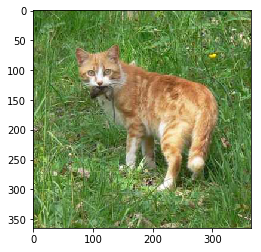

In [55]:
img = 'test8.jpg'

orig = cv2.imread(img)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

plt.imshow(orig)
plt.plot()

test = cv2.resize(cv2.imread(img), (64,64), interpolation = cv2.INTER_AREA)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test =  np.reshape(test.flatten(), (12288,1)) / 255

pred = keras_model.predict(test.T)
if np.squeeze(pred) > 0.5:
    print('It\'s a cat!')
else:
    print('It\'s not a cat')